# **Real or not? NPL with Disaster Tweets**
***
* This is the first version of the notebook
* EDA has been done. A more complete analysis can still be done
* The data can be cleaned (a lot)
* The keyword feature can be used
* Other vectorizers can be used
* Other models can be used
* Word Embeddings can be used

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline,FeatureUnion,make_pipeline
from sklearn.compose import ColumnTransformer,make_column_transformer,make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer,OneHotEncoder
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.model_selection import cross_val_score,KFold,GridSearchCV,RepeatedKFold,RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import BaseEstimator
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
from nltk.corpus  import stopwords


import warnings
warnings.simplefilter('ignore',DeprecationWarning)
warnings.simplefilter('ignore',FutureWarning)
pd.set_option("precision", 6)
sns.set_style('darkgrid')
%matplotlib inline

In [2]:
# Import datasets

train = pd.read_csv('train.csv').drop('id',axis=1)
test = pd.read_csv('test.csv')
test_id = test.id
test.drop('id',axis=1,inplace=True)
print('Train shape:',train.shape)
train.head()

Train shape: (7613, 4)


,keyword,location,text,target
0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# **EDA**

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   7552 non-null   object
 1   location  5080 non-null   object
 2   text      7613 non-null   object
 3   target    7613 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 238.0+ KB


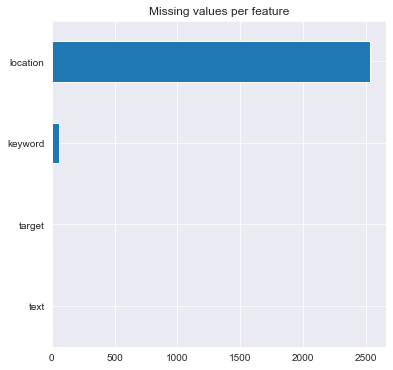

In [4]:
# Nulls
# The location feature has too many missing values
plt.figure(figsize=(6,6))
plt.title('Missing values per feature')
train.isnull().sum().sort_values(ascending=True).plot(kind='barh')
plt.show()

In [5]:
# Number of duplicated tweets
train.text.duplicated().sum()

110

In [6]:
# We drop the duplicates in order to explore the data without them

dup_train = train.drop_duplicates('text')
dup_test = test.drop_duplicates('text')

Percentage of real disasters Tweets: 0.4262


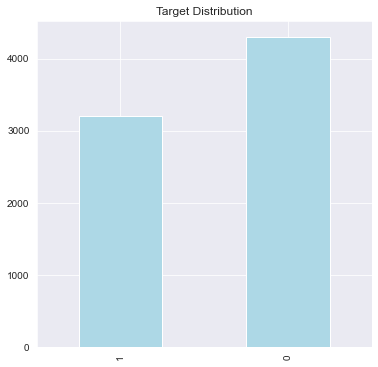

In [7]:
# Target distribution
print(f'Percentage of real disasters Tweets: {dup_train.target.mean():.4f}')
plt.figure(figsize=(6,6))
plt.title('Target Distribution')
dup_train.target.value_counts().sort_values(ascending=True).plot(kind='bar',color='lightblue')
plt.show()

### We can analyse the number of words and characters per Tweet

In [8]:
dup_train.loc[:,'characters'] = dup_train['text'].apply(lambda x: len(x))
dup_train.loc[:,'words'] = dup_train['text'].apply(lambda x: len(x.split()))
dup_train.head()

C:\Users\jinci\Anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\jinci\Anaconda3\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,keyword,location,text,target,characters,words
0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,13
1,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,7
2,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,22
3,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,8
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,16


In [9]:
# A summary of some descriptive statistics
dup_train.describe()

,target,characters,words
count,7503.000000,7503.000000,7503.000000
mean,0.426230,100.880581,14.876849
std,0.494561,33.819457,5.735043
min,0.000000,7.000000,1.000000
25%,0.000000,77.000000,11.000000
50%,0.000000,107.000000,15.000000
75%,1.000000,133.000000,19.000000
max,1.000000,157.000000,31.000000


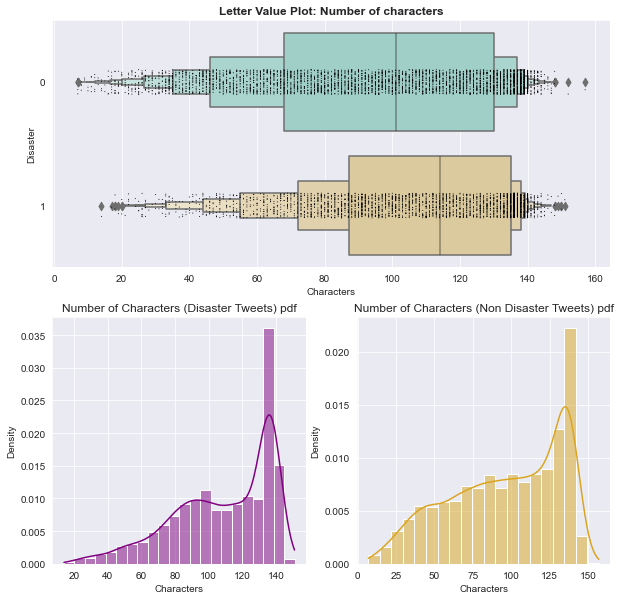

In [49]:
# Letter value plot: How the number of characters is distributed

f=plt.figure(figsize=(10,10))
ax=f.add_subplot(2,1,1)
sns.boxenplot(data=dup_train,y='target',x='characters',\
                orient='h',palette='BrBG_r')
ax.set_title('Letter Value Plot: Number of characters',fontsize=12,fontweight='bold')
sns.stripplot(data=dup_train,y='target',x='characters',\
                orient='h',color='black',size=1,ax=ax)
ax.set_xlabel('Characters')
ax.set_ylabel('Disaster')

# Probability Density Function plots

ax1 = f.add_subplot(2,2,3)
ax1.set_title('Number of Characters (Disaster Tweets) pdf')
ax1.set_xlabel('Characters')
sns.histplot(dup_train.loc[(dup_train.target==1),'characters'],
             palette='BrBG_r',ax=ax1,kde=True,color='purple',stat='density')

ax2 = f.add_subplot(2,2,4)
ax2.set_title('Number of Characters (Non Disaster Tweets) pdf')
ax2.set_xlabel('Characters')
sns.histplot(dup_train.loc[(dup_train.target==0),'characters'],
             palette='BrBG_r',ax=ax2,kde=True,color='goldenrod',stat='density')
plt.show()

It looks like when a tweet is a real disaster it tends to have more characters

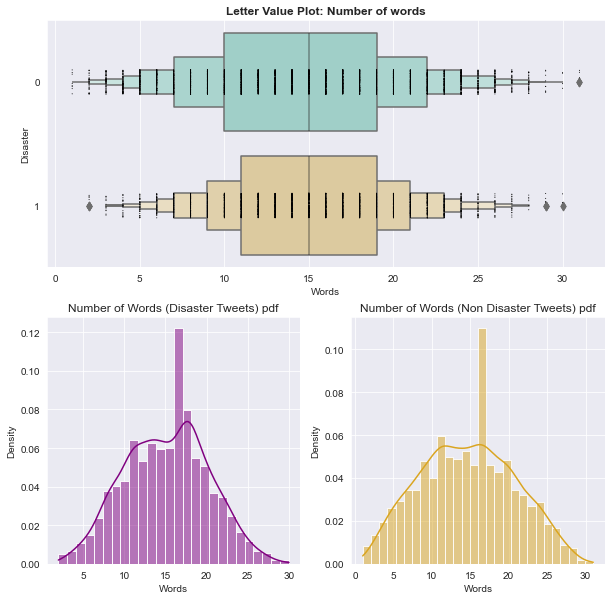

In [50]:
# Letter value plot: How the number of words is distributed

f=plt.figure(figsize=(10,10))
ax=f.add_subplot(2,1,1)
sns.boxenplot(data=dup_train,y='target',x='words',\
                orient='h',palette='BrBG_r')
ax.set_title('Letter Value Plot: Number of words',fontsize=12,fontweight='bold')
sns.stripplot(data=dup_train,y='target',x='words',\
                orient='h',color='black',size=1,ax=ax)
ax.set_xlabel('Words')
ax.set_ylabel('Disaster')

# Probability Density Function plots

ax1 = f.add_subplot(2,2,3)
ax1.set_title('Number of Words (Disaster Tweets) pdf')
ax1.set_xlabel('Words')
sns.histplot(dup_train.loc[(dup_train.target==1),'words'],
             palette='BrBG_r',ax=ax1,kde=True,color='purple',stat='density')

ax2 = f.add_subplot(2,2,4)
ax2.set_title('Number of Words (Non Disaster Tweets) pdf')
ax2.set_xlabel('Words')
sns.histplot(dup_train.loc[(dup_train.target==0),'words'],
             palette='BrBG_r',ax=ax2,kde=True,color='goldenrod',stat='density')
plt.show()

It looks like when a tweet is a real disaster it tends to have slightly more words, but the difference is not big

***
## Keyword

In [12]:
# Number of unique keywords
print(f'Number of unique keywords: {dup_train.keyword.nunique()}')

Number of unique keywords: 221


In [13]:
# grouped by keyword
# number of disaster tweets per keyword 
# percentage of disaster tweets per keyword
grouped_key = dup_train.fillna('None').groupby('keyword').agg({'target':['count','sum','mean']})
grouped_key.head()

target              
                     count sum      mean
keyword                                 
None                    56  37  0.660714
ablaze                  35  13  0.371429
accident                35  24  0.685714
aftershock              32   0  0.000000
airplane%20accident     34  29  0.852941

In [14]:
# The mean of tweets per keyword is around 34

grouped_key[('target','count')].describe().to_frame()

,target
,count
count,222.000000
mean,33.797297
std,5.043646
min,9.000000
25%,32.000000
50%,34.000000
75%,37.000000
max,56.000000


In [15]:
# The mean of true disaster tweets is about 14, but is highly variable
grouped_key[('target','sum')].describe().to_frame()

,target
,sum
count,222.000000
mean,14.405405
std,9.528598
min,0.000000
25%,6.000000
50%,13.000000
75%,22.000000
max,38.000000


In [16]:
# The mean of the percentage of disaster tweets is highly variable.
grouped_key[('target','mean')].describe().to_frame()

,target
,mean
count,222.000000
mean,0.424727
std,0.270841
min,0.000000
25%,0.182416
50%,0.378378
75%,0.657707
max,1.000000


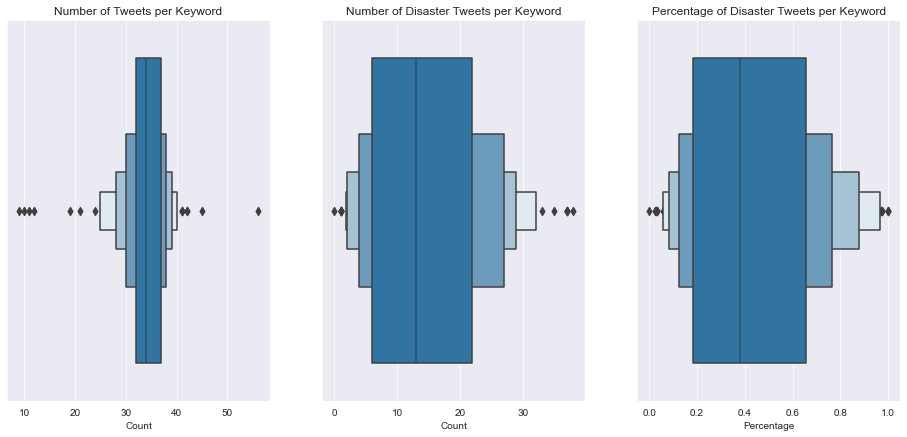

In [17]:
f = plt.figure(figsize=(16,7))
ax = f.add_subplot(1,3,1)
sns.boxenplot(grouped_key[('target','count')])
ax.set_title('Number of Tweets per Keyword')
ax.set_xlabel('Count')
ax1 = f.add_subplot(1,3,2)
sns.boxenplot(grouped_key[('target','sum')])
ax1.set_title('Number of Disaster Tweets per Keyword')
ax1.set_xlabel('Count')
ax2 = f.add_subplot(1,3,3)
sns.boxenplot(grouped_key[('target','mean')])
ax2.set_title('Percentage of Disaster Tweets per Keyword')
ax2.set_xlabel('Percentage')
plt.show()

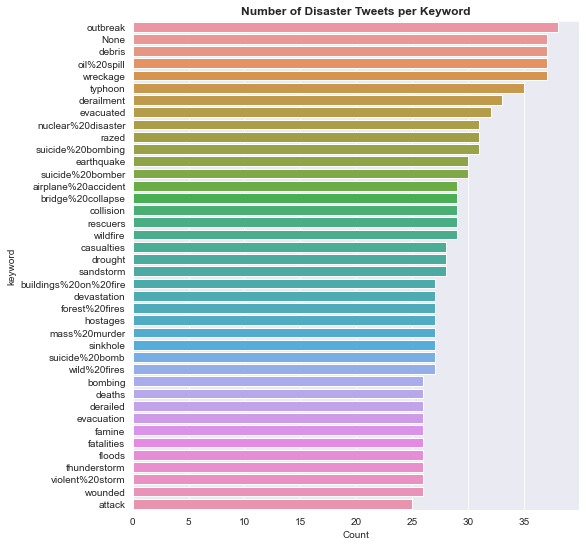

In [18]:
# number of disaster tweets per keyword 
# the 40 largest
key_count = grouped_key[('target','sum')].nlargest(40)
plt.figure(figsize=(8,9))
sns.barplot(x=key_count,y=key_count.index,orient='h')
plt.title ('Number of Disaster Tweets per Keyword',fontdict={'weight':'bold'})
plt.xlabel('Count')
plt.show()

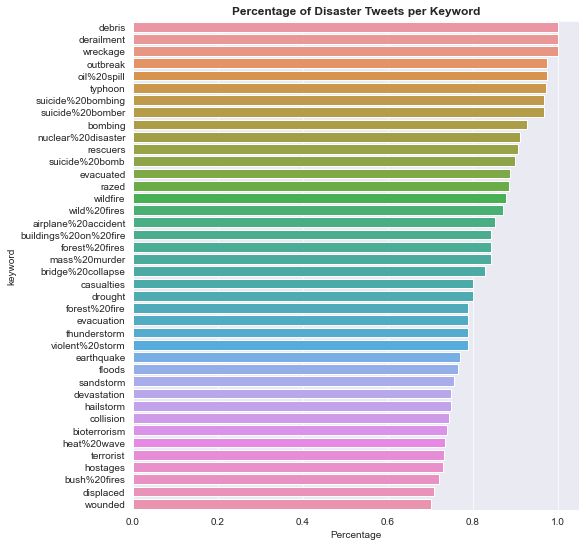

In [19]:
# percentage of disaster tweets per keyword 
# the 40 largest
key_mean = grouped_key[('target','mean')].nlargest(40)
plt.figure(figsize=(8,9))
sns.barplot(x=key_mean,y=key_mean.index,orient='h')
plt.title ('Percentage of Disaster Tweets per Keyword',fontdict={'weight':'bold'})
plt.xlabel('Percentage')
plt.show()

***
# **Modelling**
We create classes and functions in order to transform our data

In [20]:
## Lemmatizer

class Lemmatizer(BaseEstimator):
    def __init__(self):
        self.l = WordNetLemmatizer()
        
    def fit(self, x, y=None):
        return self
    
    def transform(self, x):
        x = map(lambda r:  ' '.join([self.l.lemmatize(i.lower()) for i in r.split()]), x)
        x = np.array(list(x))
        return x
    
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]
    
# stopwords

stop_words = stopwords.words('english')

# lenght of characters and words

def length_char(text):
    return (np.array(text.str.len()).reshape(-1,1))

def length_words(text):
    return np.array(text.apply(lambda x : len(x.split()))).reshape(-1,1)



In [21]:
# We build a pipe only usirand_searchhe text column
# The lemmatizer, the stopwords and the word and character counters are included in the model 

# the vectorizer... we use unigrams and bigrams 
vec = make_pipeline(Lemmatizer(),CountVectorizer(stop_words=stop_words,ngram_range=(1,2)))

# this the creates a nX2 matrix with both columns scaled
text_ = Pipeline([('text',FeatureUnion([('words',FunctionTransformer(length_words)),
                       ('char',FunctionTransformer(length_char))])),
                     ('scaler',StandardScaler())])

In [22]:
# Logistic regression as classifier
# We scale the number of words and number of characters columns

# we want to use both, the counts and the sparse matrix obtained by the vectorization
union = FeatureUnion([('count_scale',text_),
                     ('vectorizer',vec)])
# the model
model=LogisticRegression(max_iter=10000,solver='saga')

# the pipe
pipe = Pipeline([('preprocessing',union),
                 ('model',model)])

In [23]:
# GridSearch to find the best regularization hyperparameter
regul = np.linspace(0.6,1,10) # values between 0.6 and 1
params = {'model__C':regul}
kfold = KFold(shuffle=True)
grid_search = GridSearchCV(pipe,params,cv=kfold,scoring='f1').fit(dup_train.text,dup_train.target)

In [24]:
# Regularization strength
grid_search.best_params_

{'model__C': 0.6444444444444444}

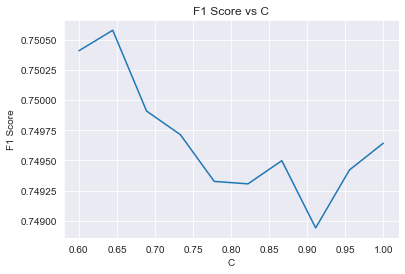

In [25]:
mean_scores = grid_search.cv_results_['mean_test_score']
plt.plot(regul,mean_scores)
plt.title('F1 Score vs C')
plt.ylabel('F1 Score')
plt.xlabel('C')
plt.show()

In [26]:
# We use our tunned model to predict
tunned_model = grid_search.best_estimator_
preds = tunned_model.predict(test.text)
sample_sub = pd.DataFrame({'id':test_id,'target':preds})
sample_sub.to_csv('sub.csv',index=False)